# 5 Noisy Data Analysis

In [1]:
import sys

sys.path.append("../../")
sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model, find_best_model

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

2023-07-21 17:24:08.868766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 17:24:08.992321: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-21 17:24:09.416151: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/anaconda3/envs/rapidfitting/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-21 17:24:09.416209: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic libr

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


## Loads Data


In [3]:
# Specify the filename and the path to save the file
filename = "data_raw_SHO.h5"
save_path = "./Data"


data_path = save_path + "/" + filename

# instantiate the dataset object
dataset = BE_Dataset(data_path, resample_bins=None, SHO_fit_func_NN=SHO_fit_func_nn,
                     )

# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
├ Noisy_Data_1_SHO_Fit
  --------

# Benchmarking on Noisy Data

To benchmark on noisy data we conducted fits using both Adam and Trust Region Optimizers. We added noise in multiples of the standard deviation of the raw data. 

Training was saved after 900 seconds.

In [4]:
basepath = "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/7_4_2023_SpeedTestTraining_Noisy"
filename = "Batch_Trainging_SpeedTest.csv"

results = find_best_model(basepath, filename)

## Visualization of Results

In [5]:
# insatiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]

BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 0), (-np.pi, np.pi)],
             image_scalebar=image_scalebar)

### Noise Level 0, ADAM Optimizer

#### Scaling the Data

When training the neural network it is useful to scale the data. We apply a global scaler such that the spectrum have a mean of 0 and a standard deviation of 1.

##### Visualizing the Scaled Data


In [ ]:
# Sets the dataset
noise = 0
optimizer = "Adam"

state = {"fitter": "LSQF", "resampled": True, "scaled": True, "label": "Scaled", "noise": noise}
dataset.set_attributes(**state)

BE_viz.nn_checker(state, filename=f"Figure_8_Scaled Raw Data_noise{noise}_optimizer_{optimizer}")

**Figure 8** shows the scaled data. The data is scaled to have a mean of 0 and a standard deviation of 1. This is done using a global scaler of the entire spectrum.

In [ ]:
dataset.LSQF_phase_shift = np.pi / 2

BE_viz.SHO_hist(
    dataset.SHO_fit_results(), filename="Figure_9_Phase_Shifted_Scaled_Histograms_noise{noise}_optimizer_{optimizer}", 
)

**Figure 9** shows the histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase

In [ ]:
X_data, Y_data = dataset.NN_data()

# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)

In [ ]:
model_name_adam = basepath + "/" + results[(noise, "Adam")]['filename'].split("//")[-1] 
model_name_trust_region = basepath + "/" + results[(noise, "Trust Region CG")]['filename'].split("//")[-1] 

# instantiate the model
model_adam = SHO_Model(dataset, training=False)

# instantiate the model
model_trust_region = SHO_Model(dataset, training=False)

model_adam.load(
    model_name_adam
)

model_trust_region.load(
    model_name_trust_region
)

### Evaluate the Neural Network Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by visualizing the best, median, and worst fits.

We will assume that the autoencoder is working correctly and thus will not consider the test train split.


In [ ]:
LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': True,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': noise}


BE_viz.MSE_compare(X_data, [model_adam, model_trust_region, LSQF_], ["Adam", "Trust Region", "LSQF"])

##### Least Squares Fit

In [ ]:

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_data,
    prediction=LSQF_,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

##### Neural Network with Adam Optimizer

In [ ]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_data,
    prediction=model_adam,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

##### Neural Network with Trust Region CG Optimizer

In [ ]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_data,
    prediction=model_trust_region,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

### Histogram of Fit Results

It is useful to view the histogram of the fitting results to apply any necessary phase shifts, and to see if the results are reasonable.


In [ ]:
# make all the histograms the same bin range.

LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': False,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': noise}

dataset.set_attributes(**LSQF_)

LSQF_params = dataset.SHO_fit_results(state = LSQF_)

# adam_params = dataset.SHO_fit_results(model = model_adam, phase_shift = np.pi / 2)

# trust_region_params = dataset.SHO_fit_results(model = model_trust_region, phase_shift = np.pi / 2)

adam_params = dataset.SHO_fit_results(model = model_adam, phase_shift = np.pi / 2)

trust_region_params = dataset.SHO_fit_results(model = model_trust_region, phase_shift = np.pi / 2)

BE_viz.SHO_hist([LSQF_params, adam_params, trust_region_params])

In [ ]:
#TODO check how the phase shift is being applied


LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': False,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': noise}

LSQF_Params = dataset.SHO_fit_results(state = LSQF_)

adam_params = dataset.SHO_fit_results(model = model_adam, phase_shift = np.pi / 2)

trust_region_params = dataset.SHO_fit_results(model = model_trust_region, phase_shift = np.pi / 2)

BE_viz.SHO_switching_maps_test([LSQF_Params, adam_params, trust_region_params], filename="Figure_15_NN_Switching_Maps", labels=["LSQF", "Adam", "SGD"])

In [ ]:
BE_viz.SHO_fit_movie_images(noise = 0, 
                            models = [None, model_adam, model_trust_region],
                            scalebar_= True, 
                            basepath = "Movies/SHO_NN_compare",  
                            filename="SHO_NN_compare",
                            phase_shift = [None, np.pi / 2, np.pi / 2])

In [ ]:
# this is code to fix the csv. We should not need this in the future


# import pandas as pd

# # Read the CSV
# df = pd.read_csv('/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/7_4_2023_SpeedTestTraining_Noisy/Batch_Trainging_SpeedTest.csv')

# # Update the 'filename' column
# df['filename'] = df['filename'].apply(lambda x: x.replace('model_epoch', f'model_optimizer_{df["Optimizer"]}_epoch'))

# # Write the updated DataFrame back to CSV
# df.to_csv('/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/7_4_2023_SpeedTestTraining_Noisy/Batch_Trainging_SpeedTest_3.csv', index=False)


In [ ]:
#TODO add fix for filename to the base code

### Noise Level 6, ADAM Optimizer

#### Scaling the Data

When training the neural network it is useful to scale the data. We apply a global scaler such that the spectrum have a mean of 0 and a standard deviation of 1.

##### Visualizing the Scaled Data



    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = None
    NN Phase Shift = None
    Noise Level = 6
                  
./Figures/Figure_8_Scaled Raw Data_noise6_optimizer_Adam.png
./Figures/Figure_8_Scaled Raw Data_noise6_optimizer_Adam.svg


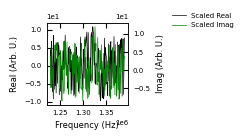

In [6]:
# Sets the dataset
noise = 6
optimizer = "Adam"

state = {"fitter": "LSQF", "resampled": True, "scaled": True, "label": "Scaled", "noise": noise}
dataset.set_attributes(**state)

BE_viz.nn_checker(state, filename=f"Figure_8_Scaled Raw Data_noise{noise}_optimizer_{optimizer}")

**Figure 8** shows the scaled data. The data is scaled to have a mean of 0 and a standard deviation of 1. This is done using a global scaler of the entire spectrum.


    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
./Figures/Figure_9_Phase_Shifted_Scaled_Histograms_noise{noise}_optimizer_{optimizer}.png
./Figures/Figure_9_Phase_Shifted_Scaled_Histograms_noise{noise}_optimizer_{optimizer}.svg


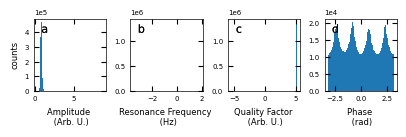

In [7]:
dataset.LSQF_phase_shift = np.pi / 2

BE_viz.SHO_hist(
    dataset.SHO_fit_results(), filename="Figure_9_Phase_Shifted_Scaled_Histograms_noise{noise}_optimizer_{optimizer}", 
)

**Figure 9** shows the histograms of the scaled a) amplitude, b) resonance frequency, c) quality factor, and d) phase. Note there is a transformation applied to the phase

In [8]:
X_data, Y_data = dataset.NN_data()

# constructs a test train split
X_train, X_test, y_train, y_test = dataset.test_train_split_(shuffle=True)


    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None

    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = True
    Output Shape = pixels
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None


In [9]:
model_name_adam = basepath + "/" + results[(noise, "Adam")]['filename'].split("//")[-1] 
model_name_trust_region = basepath + "/" + results[(noise, "Trust Region CG")]['filename'].split("//")[-1] 

# instantiate the model
model_adam = SHO_Model(dataset, training=False)

# instantiate the model
model_trust_region = SHO_Model(dataset, training=False)

model_adam.load(
    model_name_adam
)

model_trust_region.load(
    model_name_trust_region
)

Using GPU NVIDIA GeForce RTX 3090
Using GPU NVIDIA GeForce RTX 3090


### Evaluate the Neural Network Results

It is always recommended to validate that the autoencoder is working correctly. We can do this by visualizing the best, median, and worst fits.

We will assume that the autoencoder is working correctly and thus will not consider the test train split.


In [10]:
LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': True,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': noise}


BE_viz.MSE_compare(X_data, [model_adam, model_trust_region, LSQF_], ["Adam", "Trust Region", "LSQF"])

Adam Mean Squared Error: 23.7763
Trust Region Mean Squared Error: 23.7791
LSQF Mean Squared Error: 26.3559


##### Least Squares Fit

./Figures/Figure_10_NN_validation_Train.png
./Figures/Figure_10_NN_validation_Train.svg


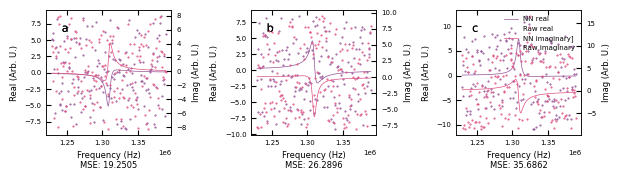

In [11]:

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_data,
    prediction=LSQF_,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

##### Neural Network with Adam Optimizer

./Figures/Figure_10_NN_validation_Train.png
./Figures/Figure_10_NN_validation_Train.svg


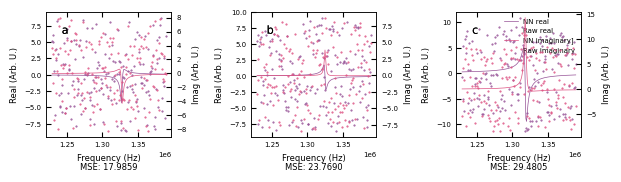

In [12]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_data,
    prediction=model_adam,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

##### Neural Network with Trust Region CG Optimizer

./Figures/Figure_10_NN_validation_Train.png
./Figures/Figure_10_NN_validation_Train.svg


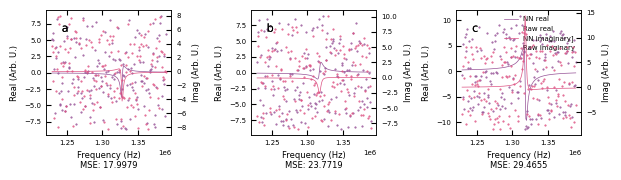

In [13]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_data,
    prediction=model_trust_region,
    out_state={"scaled": True, "raw_format": "complex"},
    returns=True,
    filename="Figure_10_NN_validation_Train",
)

### Histogram of Fit Results

It is useful to view the histogram of the fitting results to apply any necessary phase shifts, and to see if the results are reasonable.



    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None

    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None

    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  

    Dataset = Noi

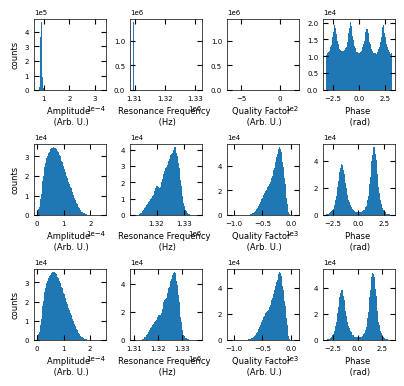

In [14]:
# make all the histograms the same bin range.

LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': False,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': noise}

dataset.set_attributes(**LSQF_)

LSQF_params = dataset.SHO_fit_results(state = LSQF_)

# adam_params = dataset.SHO_fit_results(model = model_adam, phase_shift = np.pi / 2)

# trust_region_params = dataset.SHO_fit_results(model = model_trust_region, phase_shift = np.pi / 2)

adam_params = dataset.SHO_fit_results(model = model_adam, phase_shift = np.pi / 2)

trust_region_params = dataset.SHO_fit_results(model = model_trust_region, phase_shift = np.pi / 2)

BE_viz.SHO_hist([LSQF_params, adam_params, trust_region_params])


    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None

    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = index
    Measurement State = all
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None
(1382400, 4)
(1382400, 4)
(1382400, 4)
./Figures/Figure_15_NN_Switching_Maps.png
./Figures/Figure_15_NN_Switching_Maps.svg


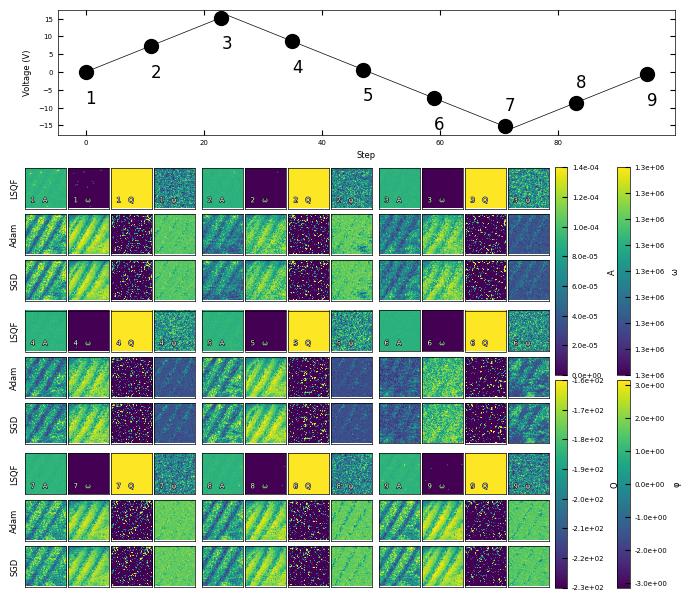

In [15]:
#TODO check how the phase shift is being applied


LSQF_ = {'resampled': True,
                'raw_format': 'complex',
                'fitter': 'LSQF',
                'scaled': False,
                'output_shape': 'index',
                'measurement_state': 'all',
                'resampled_bins': 165,
                'LSQF_phase_shift': 1.5707963267948966,
                'NN_phase_shift': None,
                'noise': noise}

LSQF_Params = dataset.SHO_fit_results(state = LSQF_)

adam_params = dataset.SHO_fit_results(model = model_adam, phase_shift = np.pi / 2)

trust_region_params = dataset.SHO_fit_results(model = model_trust_region, phase_shift = np.pi / 2)

BE_viz.SHO_switching_maps_test([LSQF_Params, adam_params, trust_region_params], filename="Figure_15_NN_Switching_Maps", labels=["LSQF", "Adam", "SGD"])

In [16]:
BE_viz.SHO_fit_movie_images(noise = 6, 
                            models = [None, model_adam, model_trust_region],
                            scalebar_= True, 
                            basepath = "Movies/SHO_NN_compare",  
                            filename="SHO_NN_compare",
                            phase_shift = [None, np.pi / 2, np.pi / 2])


    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = on
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None

    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = off
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None

    Dataset = Noisy_Data_6
    Resample = True
    Raw Format = complex
    fitter = LSQF
    scaled = False
    Output Shape = pixels
    Measurement State = on
    Resample Resampled = True
    Resample Bins = 165
    LSQF Phase Shift = 1.5707963267948966
    NN Phase Shift = None
    Noise Level = 6
                  
None

    Dataset